### **Topic Modelling on Disneyland Reviews(California).**

Our analysis involves customer reviews and ratings from three Disney branches. Customers have rated their experiences on a scale of 1 to 5, with ratings of 1 to 3 indicating negative review and ratings of 4 and 5 indicating positive review.

We will conduct separate topic modeling analyses on the positive and negative reviews for each branch. Our aim is to identify the topics that are contributing to positive feedback and attracting customers, as well as the topics that are leading to negative feedback.Identifying the positive aspects will help us understand the reasons for customer footfall and identifying the negative aspects will enable us to address the issues and improve the overall customer experience.

We aim to perform Topic modeling for each branch, extracting topics on a monthly and seasonal basis. Our aim was to explore how the topics discussed by people are influenced by the month or season

Our ultimate goal is to help the Disneyland authorities address customer feedback and improve their services.


**We will be focussing on Disneyland California in this notebook**

### **Research questions**

1. a. What are the key topics mentioned in positive customer reviews of Disneyland California
   b. Key topics mentioned in negative customer reviews of Disneyland California
2. How do these topics vary across different months in Disneyland California.
3. How do these topics vary across different seasons in Disneyland California.
4. How can this information be used to enhance the customer experience and address any issues affecting customer satisfaction.

### **Table of contents**


1. **Topic Modeling for California**<br>
    a. For Positive Reviews<br>
    b. For Negative Reviews<br>
2. **Topics across different months** : Learn k topics across all the reviews and then compute average topic distribution month by month.See change in topic distribution and analyze the reason<br>
3. **Topics across different seasons** : Learn k topics across all the reviews and then compute average topic distribution across season.See change in topic distribution and analyze the reason<br>
4. **Suggestions for Disneyland California**

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import names 
import random
import nltk 
import calendar
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
import pandas as pd
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
import re
from nltk.corpus import treebank
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from gensim import corpora
import gensim
from gensim.models.coherencemodel import CoherenceModel

### Reading Data and Data Preprocessing

In [2]:
reviews_df = pd.read_csv('/Users/aasthatandon/Library/Mobile Documents/com~apple~CloudDocs/CSUEB materials/Spring 2023/BAN 676/Project/BAN675/Team Project/Data/DisneylandReviews.csv', encoding='latin-1')
reviews_df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


##### Branch

In [3]:
reviews_df['Location'] = reviews_df.Branch.str[11:]
reviews_df.drop(columns="Branch", inplace=True)
reviews_df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Location
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",HongKong


##### Removing Missing Year_Month

In [4]:
#To select rows whose column value equals 'missing' in 'Year_Month':
missing = reviews_df.loc[reviews_df['Year_Month'] == 'missing']
#keep the missing rows seperate
reviews_df = reviews_df[reviews_df.Year_Month != 'missing']
reviews_df.shape

(40043, 6)

##### Extracting Year and Month

In [5]:
reviews_df['Year'] = pd.DatetimeIndex(reviews_df['Year_Month']).year
reviews_df['Year'] = pd.to_numeric(reviews_df['Year'])
reviews_df['Month'] = pd.DatetimeIndex(reviews_df['Year_Month']).month
reviews_df['Month'] = pd.to_numeric(reviews_df['Month'])
reviews_df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Location,Year,Month
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4


In [6]:
reviews_df.drop('Year_Month', axis=1, inplace = True)
reviews_df = reviews_df.reset_index(drop=True)
reviews_df.head(5)

,Review_ID,Rating,Reviewer_Location,Review_Text,Location,Year,Month
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4


##### Data Cleaning

In [7]:
# Clean out Disney location references and ride references
reviews_df['Review_Text'] = reviews_df['Review_Text'].str.replace(r"disney(?:land| park)?|park|place|hong kong|hk|cali|california|paris|pa|fr|Disneyland Railroad|\
                            Great Moments with Mr. Lincoln | Lincoln| The Disney Gallery | Gallery| Main Street Vehicles | \
                            Main Street Cinema | Main Street | Walt Disney's Enchanted Tiki Room | Enchanted Tiki Room | Jungle Cruise | \
                            Indiana Jones | Pirates of the Caribbean | Haunted Mansion | \
                            Davy Crockett Explorer Canoes | Davy Crockett | Explorer Canoes | Many Adventures of Winnie the Pooh | Winnie the Pooh | Splash Mountain | \
                            Big Thunder Mountain Railroad | Mark Twain Riverboat | Mark Twain | Frontierland Shootin Exposition |Frontierland| \
                            Pirate's Lair on Tom Sawyer Island | Pirate's Lair | Tom Sawyer | Sailing Ship Columbia | \
                            Mickey's House | Meet Mickey | Minnie's House | Roger Rabbit's Car Toon Spin | Roger Rabbit | \
                            Chip 'n' Dale's Gadget Coaster | Gadget Coaster | Fantasyland Theatre | It's a Small World | Small World | \
                            Mr. Toad's Wild Ride | Peter Pan's Flight | Pinocchio's Daring Journey | Pixie Hollow |\
                            Snow White's Enchanted Wish | Snow White | Enchanted Wish | Storybook Land Canal Boats | Storybook Land| Canal Boats |Dumbo the Flying Elephant | Dumbo |\
                            Casey Jr. Circus Train | Circus Train | Alice in Wonderland | Matterhorn Bobsleds | Bobsleds | King Arthur Carrousel | King Arthur |\
                            Mad Tea Party | Sleeping Beauty Castle Walkthrough | Sleeping Beauty| Astro Orbiter | \
                            Autopia Star Tours – The Adventures Continue | Autopia Star Tours | Buzz Lightyear Astro Blasters | Buzz Lightyear | Astro Blasters |\
                            Space Mountain | Monorail | Finding Nemo Submarine Voyage | Finding Nemo | Submarine Voyage |\
                            Star Wars Launch Bay | Star Wars | Millennium Falcon: Smuggler's Run | Millennium Falcon | Smuggler's Run| Rise of the Resistance | \
                            Electrical Parade | Galaxy's Edge | Tomorrowland | Fantasyland | \
                            Mickey's Toontown | Toontown | Frontierland | Critter Country | New Orleans Square | Adventureland | \
                            Main Street, U.S.A.| toy story | lion king | main street | small world | sce mountain | \
                            story land | king show | mickey mouse | grizzly gulch | mystic manor | \
                            big thunder mountain | chinese new year | slinky dog ride | jungle river cruise | lion king show | \
                            toy story| festival lion king | runaway mine cars | mine cars | iron man |\
                            big grizzly mountain | sunny bay station | small world | mountain runaway mine | \
                            iron man experience | sleeping beauty castle | sce mountain | buzz light year | \
                            big thunder | iron man experience | mickey | minnie | \
                            big grizzley | buzz lightyear | mountain",'')

/var/folders/w4/m7nmrzlx639_9y3p7hm312p40000gn/T/ipykernel_20035/4290222359.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews_df['Review_Text'] = reviews_df['Review_Text'].str.replace(r"disney(?:land| park)?|park|place|hong kong|hk|cali|california|paris|pa|fr|Disneyland Railroad|\


In [8]:
common_words1 = ["disneyland","disneyland_Paris","disneyland_HongKong","usa","world",
                 "disneyworld","disney","kong","hong","paris","california","States","park","ok",
                "one","go","get","the", "them", "your","us","lot","day","hk","realli","would","take","also",
                "year","see","land","much","great","visit","time","kid","went","even","around","children",
                "place","attract","ticket","mani","everi","still","back","peopl","etc", "dont","make","take","now","ride","om",
                "like","good","small","ss","comr","line","iendli","want","could","wait","alway","way","got","indiana","sce"]

Note : This words removals are based on multiple iteration

##### California Branch

In [9]:
#Define California Branch
cal_df = reviews_df[reviews_df['Location']=='California']
cal_df.head()

,Review_ID,Rating,Reviewer_Location,Review_Text,Location,Year,Month
9147,670801367,5,United States,This has always been and forever will be spec...,California,2019,4
9148,670760708,5,United States,A great day of simple fun and thrills. Bring c...,California,2019,4
9149,670565072,4,Australia,All and all a great day was had. The crowds ar...,California,2019,5
9150,670544335,5,United States,Having been to the Florida location numerous t...,California,2019,4
9151,670472278,5,Canada,"Had the 4 day ss, spent 3 at DL and one at CA....",California,2019,4


We will classify 4 and 5 as positives and 1,2,3, as negative reviews and make two list corresponding to them

### 1 a. Build the Topic Model for Disneyland California Positive Reviews

In [10]:
def sentiment(df):
    pos_reviews=[]
    neg_reviews=[]
    for idx,row in df.iterrows():
        if row['Rating']==4 or row['Rating']==5:
            pos_reviews.append(row['Review_Text'])
        else:
            neg_reviews.append(row['Review_Text'])
    return pos_reviews,neg_reviews

In [11]:
cal_pos_reviews, cal_neg_reviews = sentiment(cal_df)
cal_pos_reviews[0]

'This  has always been and forever will be special. The feeling you get entering the , seeing the characters and different attractions is just priceless. This is definitely a dream trip for all ages, especially young kids. Spend the money and go to Disneyland, you will NOT regret it'

In [12]:
###  select the number of topics ###check on this 
stop = stopwords.words('english')
def clean(doc):
    """
    Clean review
    args:
        doc: review (stry type)
    returns:
        cleaned review
    """
    stemmer=PorterStemmer()
    lowercase=[i.lower() for i in nltk.word_tokenize(doc) if i.lower() not in stop and i.isalpha()] 
    normalized=[stemmer.stem(i) for i in lowercase]
    normalized = [i for i in normalized if i not in common_words1]
    
    return normalized

def grid_search_on_num_topics(reviews, topics = [2,3,4,5,6,7]):
    """
    Do grid search on number of topics for topic modelling.
    args:
        reviews: list of reviews (list of str types)
    returns:
        
    """
    Lda = gensim.models.ldamodel.LdaModel
    contents=[clean(x) for x in reviews]
    dictionary = corpora.Dictionary(contents)
    #preparing data
    doc_term_matrix=[dictionary.doc2bow(doc) for doc in contents]# frequency of words in dict

    for i in topics:
        ldamodel = Lda(
            doc_term_matrix, num_topics=i, id2word = dictionary, passes=50, chunksize=10
        )
        #computing coherence score for the model
        cm = CoherenceModel(model=ldamodel,texts=contents, corpus=doc_term_matrix, coherence='c_v', processes=5)
        coherence = cm.get_coherence()
        print(f"with {i} topics, the coherence is {coherence}" )
        
        # Compute Perplexity
        #perplexity = ldamodel.log_perplexity(doc_term_matrix)
        #print('\nPerplexity: ', ldamodel.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.
        #print(f"with {i} topics, the coherence is {coherence} , perplexity is {perplexity}" )
        
        # Compute Coherence Score
        #coherence_model_lda22 = CoherenceModel(model=lda_model22, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        #coherence_lda22 = coherence_model_lda22.get_coherence()
        #print('\nCoherence Score: ', coherence_lda22)

# the bigger the coherence, the better the model coherence
# we pick the number of topics that when the increase of coherence score becomes slower



In [13]:
grid_search_on_num_topics(cal_pos_reviews, topics = [2,4,6])

with 2 topics, the coherence is 0.4020021173154029
with 4 topics, the coherence is 0.3922914896502858
with 6 topics, the coherence is 0.34048429393947616


In [140]:
def topic_model(reviews,num_topics=2):
    Lda = gensim.models.ldamodel.LdaModel
    contents = [clean(x) for x in reviews]
    dictionary = corpora.Dictionary(contents)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in contents]
    ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary)
    return ldamodel, dictionary


In [141]:
cal_ldamodel_pos, _ = topic_model(cal_pos_reviews,num_topics=2)
print(cal_ldamodel_pos.print_topics(num_topics=2, num_words=10))

[(0, '0.010*"fast" + 0.010*"show" + 0.008*"enjoy" + 0.007*"adventur" + 0.007*"hour" + 0.007*"earli" + 0.006*"use" + 0.006*"crowd" + 0.006*"long" + 0.006*"mountain"'), (1, '0.015*"love" + 0.012*"fun" + 0.010*"food" + 0.008*"crowd" + 0.008*"famili" + 0.007*"first" + 0.007*"well" + 0.006*"old" + 0.006*"magic" + 0.006*"everyth"')]


In [142]:
#Plot Wordcloud of Top 10 words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def topic_wordcloud(ldamodel,num_topics=2):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(stopwords=stop,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = ldamodel.show_topics(formatted=False)
    row = num_topics//2

    fig, axes = plt.subplots(row, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show();
    

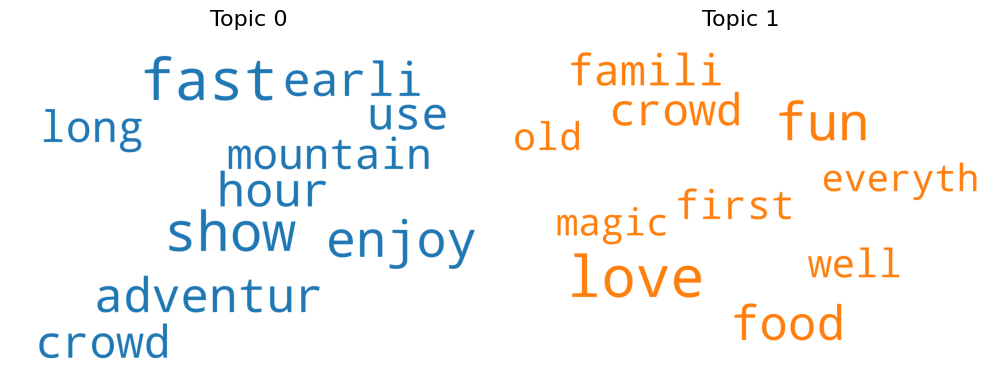

In [143]:
topic_wordcloud(cal_ldamodel_pos,num_topics=2)

Topic 0: Theme Park Attractions and Shows Experience<BR>
This topic focuses on visitors' experiences with the theme park attractionsand shows, such as wait times, enjoyment levels, and timing of visits. It also includes tips on avoiding long crowds and making the most of early hours.

Topic 1: Overall Theme Park Experience<BR>
This topic covers the overall experience of visiting the theme park, including food and dining, crowd levels, family-friendliness, and the general atmosphere of the park. It may includes visitors' love for the park and recommendations for first-time visitors.

### 1 b. Build the Topic Model for Disneyland California Negative Reviews

In [14]:
grid_search_on_num_topics(cal_neg_reviews, topics = [2,4,6])

with 2 topics, the coherence is 0.34417291358103114
with 4 topics, the coherence is 0.2871288096795144
with 6 topics, the coherence is 0.3024021706878259


In [145]:
cal_ldamodel_neg, _ = topic_model(cal_neg_reviews)
print(cal_ldamodel_neg.print_topics(num_topics=2, num_words=10))

[(0, '0.009*"hour" + 0.008*"minut" + 0.008*"crowd" + 0.008*"close" + 0.006*"long" + 0.006*"disappoint" + 0.005*"fast" + 0.005*"first" + 0.005*"food" + 0.005*"money"'), (1, '0.011*"crowd" + 0.007*"long" + 0.007*"price" + 0.007*"food" + 0.007*"hour" + 0.006*"famili" + 0.006*"fast" + 0.005*"thing" + 0.005*"trip" + 0.005*"two"')]


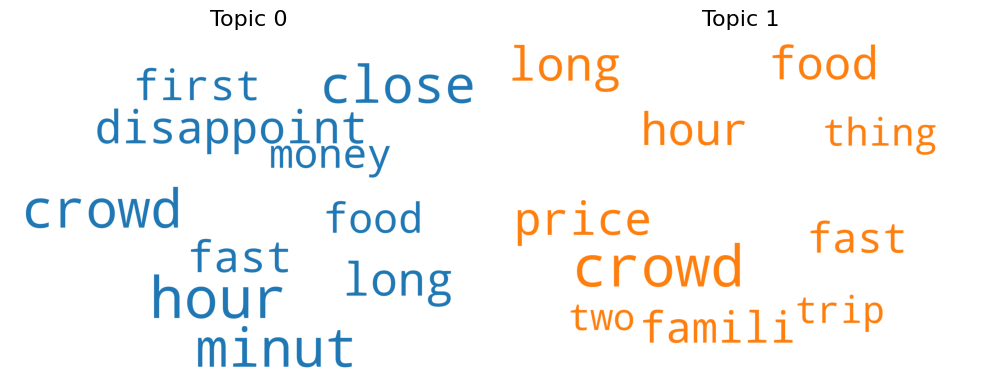

In [146]:
topic_wordcloud(cal_ldamodel_neg,num_topics=2)

Topic 0 : Disappointing Crowd Experience<BR>
One negative topic that can be derived from these phrases could be the disappointment that the crowd experience brings. With words like "crowd", "close," and "long","hour","minut" suggests that the crowds are overwhelming causing long hour delays , and the experience is not enjoyable.

Topic 1 :Unsatisfactory Food and Price at Crowded Restaurant<BR>
Another negative topic that can be derived from these phrases could be the unsatisfactory food and price. Words like "food," "price," and "money" suggest that the food is not worth the price paid for it, and the overall experience was not good.

### 2. Topics across different months :

Learn k topics across all the reviews and then compute average topic distribution across month.See change in topic distribution and analyze the reason

In [13]:
cal_all_reviews = cal_pos_reviews + cal_neg_reviews
random.shuffle(cal_all_reviews)

In [14]:
grid_search_on_num_topics(cal_all_reviews, topics = [2,4,6])

with 2 topics, the coherence is 0.40887446623057583
with 4 topics, the coherence is 0.37762925473032544
with 6 topics, the coherence is 0.33010705390740286


In [149]:
cal_ldamodel_all, cal_dictionary_all = topic_model(cal_all_reviews,num_topics=4)
print(cal_ldamodel_all.print_topics(num_topics=4, num_words=10))

[(0, '0.013*"crowd" + 0.009*"long" + 0.009*"hour" + 0.008*"price" + 0.007*"famili" + 0.007*"love" + 0.007*"food" + 0.007*"fun" + 0.007*"experi" + 0.007*"enjoy"'), (1, '0.013*"old" + 0.011*"love" + 0.010*"halloween" + 0.009*"enjoy" + 0.008*"experi" + 0.007*"christma" + 0.007*"better" + 0.007*"theme" + 0.006*"new" + 0.006*"differ"'), (2, '0.011*"firework" + 0.011*"love" + 0.010*"rade" + 0.010*"show" + 0.008*"fast" + 0.007*"charact" + 0.007*"first" + 0.007*"crowd" + 0.007*"night" + 0.006*"amaz"'), (3, '0.012*"fast" + 0.010*"use" + 0.009*"love" + 0.009*"magic" + 0.008*"food" + 0.008*"first" + 0.007*"fun" + 0.007*"plan" + 0.007*"adventur" + 0.007*"walk"')]


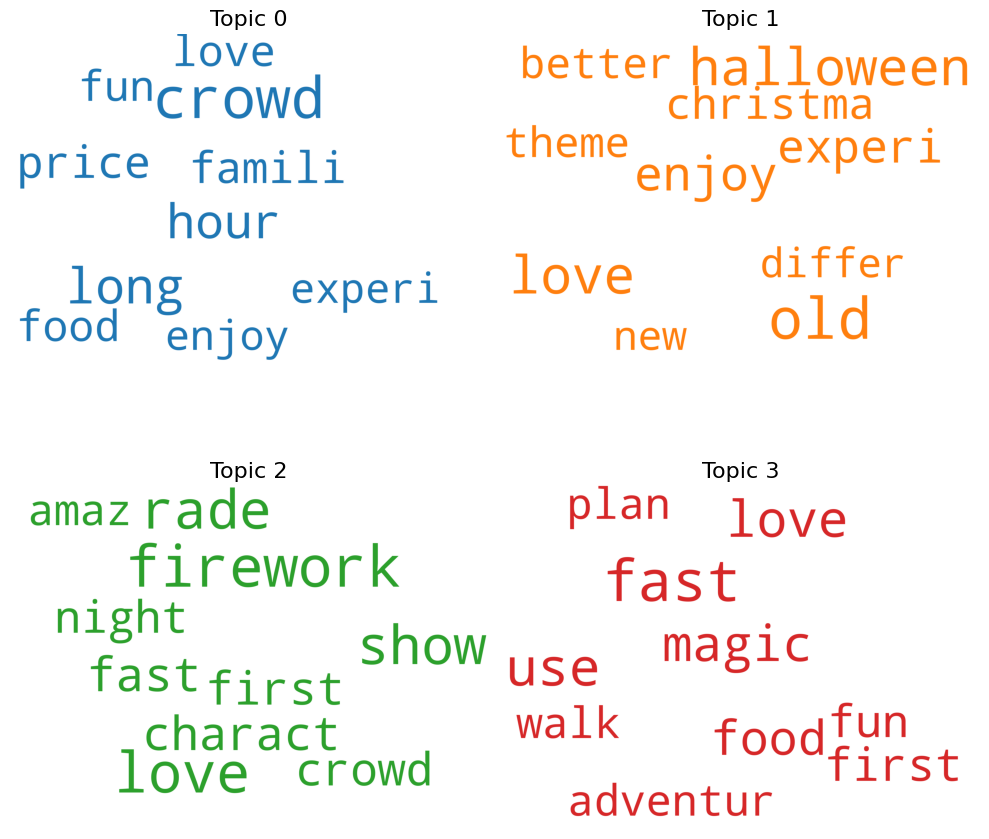

In [150]:
topic_wordcloud(cal_ldamodel_all, num_topics = 4)

Topic 0 : Crowd management<BR>
This topic can cover the management of the crowd at Disneyland California. The discussion can revolve around the strategies used by the management to control crowds, the peak hours, and the off-peak hours, how the prices of the tickets affect the crowd, and the overall experience of the visitors.

Topic 1 : Festive experiences<BR>
This topic can cover the festive experiences, such as Halloween and Christmas celebrations. The discussion can revolve around the different themes, the decorations,and the overall experience of celebrating these festivals at Disneyland California.

Topic 2: Fireworks and parade shows<BR>
This topic can cover the fireworks and parade shows. The discussion can revolve around the different shows, the timings, the characters, and the overall experience of watching these shows. It can also discuss how to make the most of these shows and what to expect from them.

Topic 3 : Fastpass enhancing Magical adventures<BR>
This topic can cover the different attractions, and experiences. The discussion can revolve around the most popular attractions, how to plan your visit using fastpass, and the overall experience of going on a magical adventure at Disneyland California.

### 3. Topics across different months :

Learn k topics across all the reviews and then compute average topic distribution across season.See change in topic distribution and analyze the reason

Average topic distribution for each month for California

In [156]:
def get_reviews_by_month(df):
    month_review = {m:[] for m in range(1,13)}
    for month in month_review:
        mon_true = df['Month'] == month
        reviews = list(df[mon_true]['Review_Text'])
        month_review[month] = reviews
    return month_review

In [157]:
cal_month_reviews = get_reviews_by_month(cal_df)

In [158]:
# write a functon that returns average topic distribution 
def get_avg_topic_dist(ldamodel, dictionary, reviews, num_topics=2):
    review_topic_dist = []
    for review in reviews:
        clean_review = clean(review)
        doc_term_matrix = [dictionary.doc2bow(clean_review)]
        topic_dist = ldamodel.get_document_topics(doc_term_matrix[0]) #get topic distribution
        template_dict=dict.fromkeys(range(num_topics),0) # we need to fill the missing topics in the distribution (missing because the loading is 0), this is to create a template of empty dictionary with all 0 values
        template_dict.update(topic_dist)
        topic_dist = [v for k,v in template_dict.items()]
        review_topic_dist.append(topic_dist)
    
    arr_topic_dist = np.asarray(review_topic_dist)
    review_topic_dist = list(np.mean(arr_topic_dist,axis=0))     
    return review_topic_dist


In [159]:
def plot_avg_topic_dist(avg_topic_dist, prefix=""):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=150)
    num_topics = len(avg_topic_dist)
    ax.bar(range(0, num_topics),avg_topic_dist)
    ax.set_title(prefix + "Average topic distribution")
    ax.set_xlabel("Topic Number")
    ax.set_ylabel("Topic weight")
    ax.set_ylim(0,1)
    ax.set_xticks(range(0, num_topics))
    ax.grid(alpha=0.1)
    plt.show()

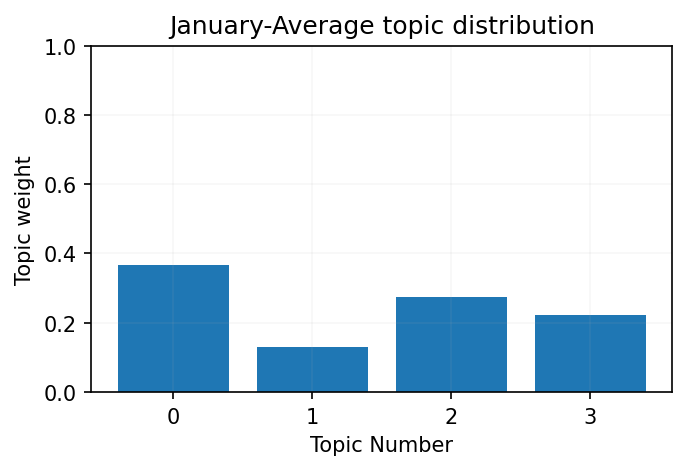

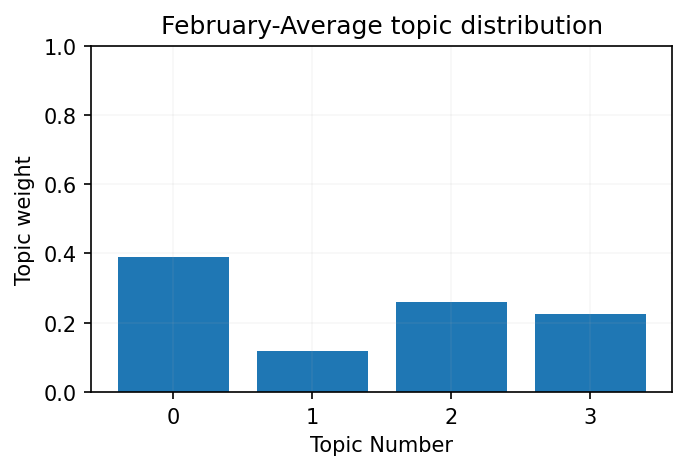

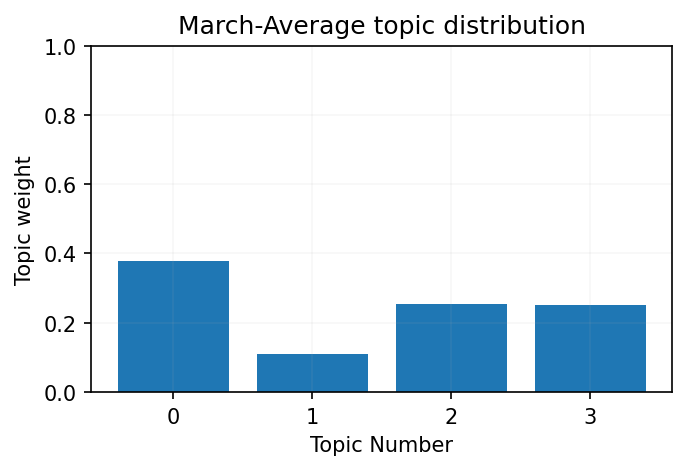

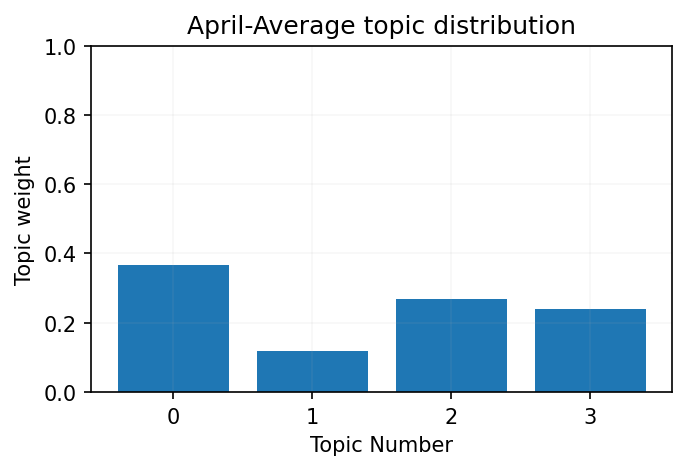

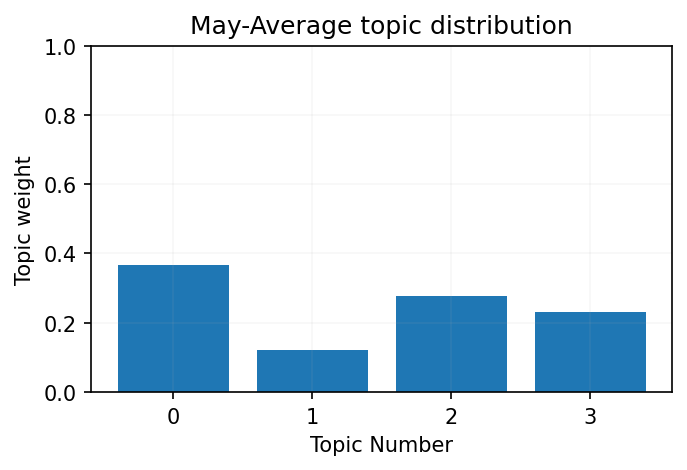

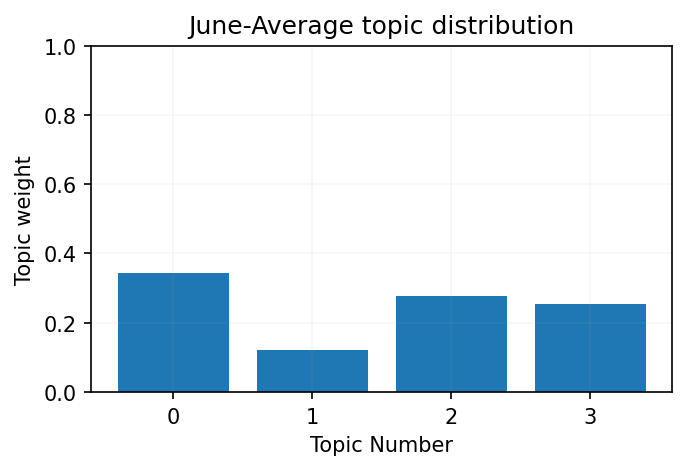

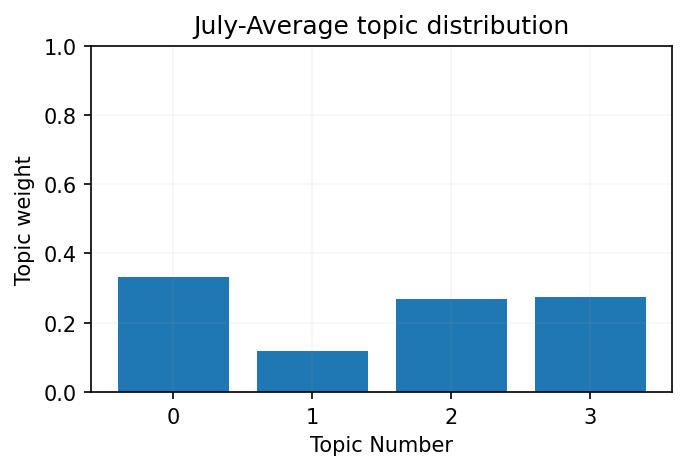

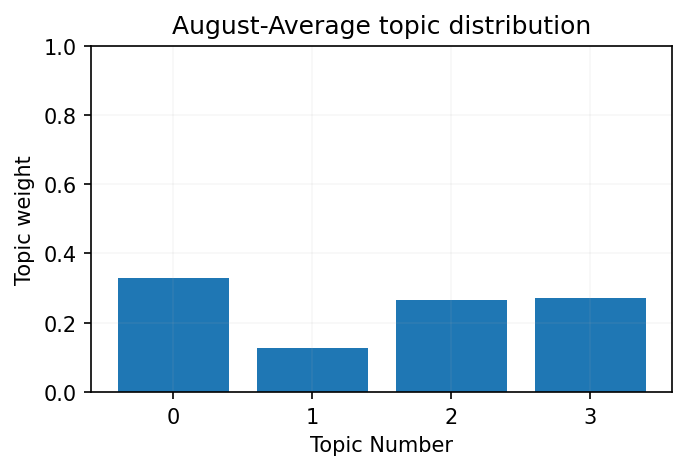

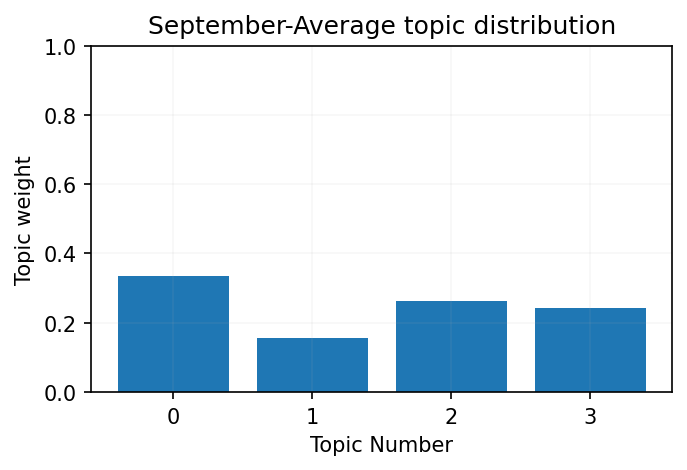

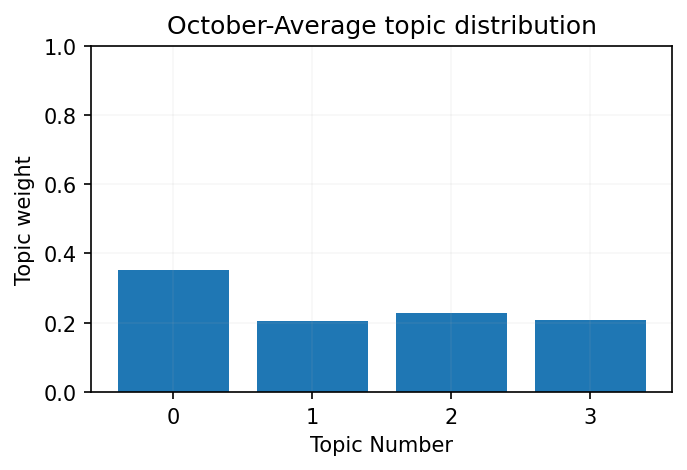

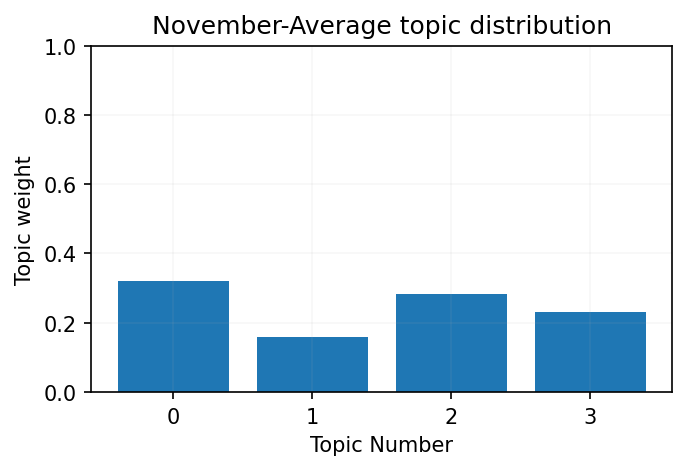

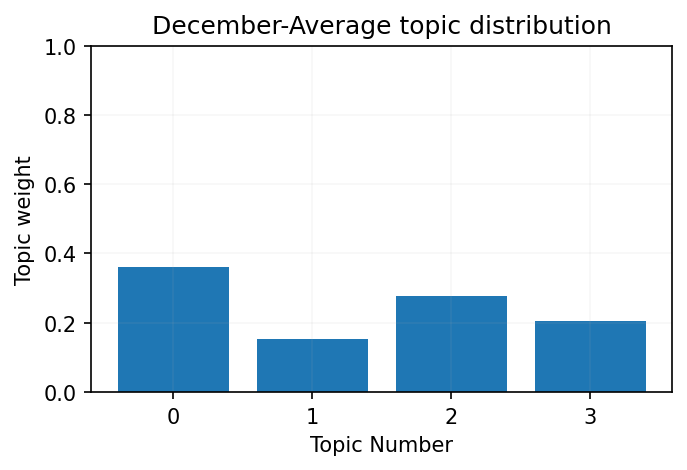

In [160]:
for month,reviews in cal_month_reviews.items():
    avg_topic_dist = get_avg_topic_dist(
        cal_ldamodel_all, cal_dictionary_all , cal_month_reviews[month],num_topics=4
    )
    #print(avg_topic_dist)
    month_string = calendar.month_name[month]
    plot_avg_topic_dist(avg_topic_dist,prefix=month_string + '-')

Topic 0 is most talked and Topic 1 is least talked throughout the year

4.5 Learn k topics across all the reviews and then compute average topic distribution across season.See change in topic distribution and analyze the reason

Average topic distribution for each season for California

In [161]:
def get_season_df(df):
    def find_season(month):
        season_month = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Fall', 10:'Fall', 11:'Fall'}
        return season_month.get(month)

    season_list = []
    for month in df['Month']:
        season = find_season(month)
        season_list.append(season)
    df['Season'] = season_list
    return df

In [163]:
def get_reviews_by_season(df):
    df = get_season_df(df)
    season_review = {s:[] for s in ["Summer","Winter","Spring","Fall"]}
    for season in season_review:
        sea_true = df['Season'] == season
        reviews = list(df[sea_true]['Review_Text'])
        season_review[season] = reviews
    return season_review


In [164]:
cal_season_reviews = get_reviews_by_season(cal_df)

/var/folders/w4/m7nmrzlx639_9y3p7hm312p40000gn/T/ipykernel_18148/3732913003.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = season_list


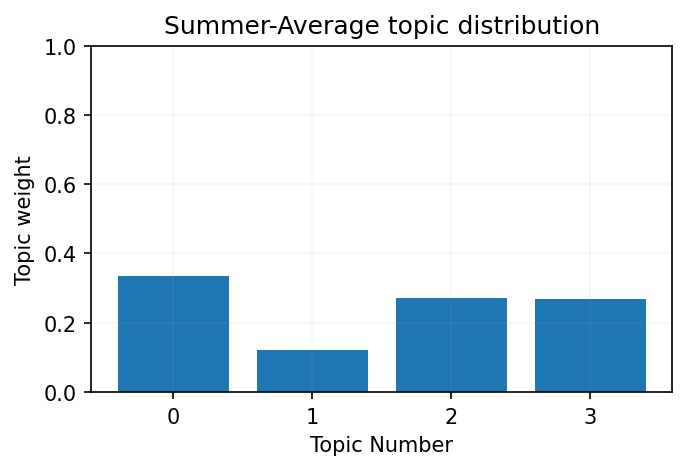

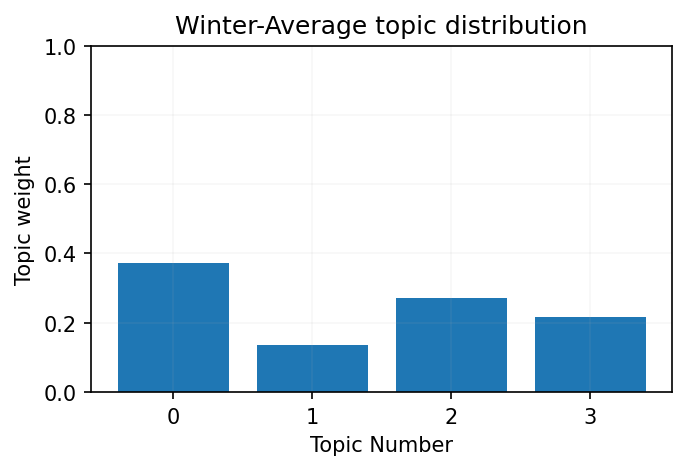

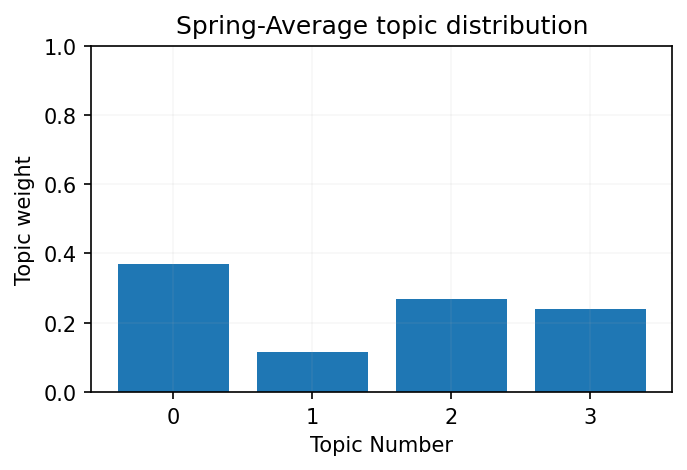

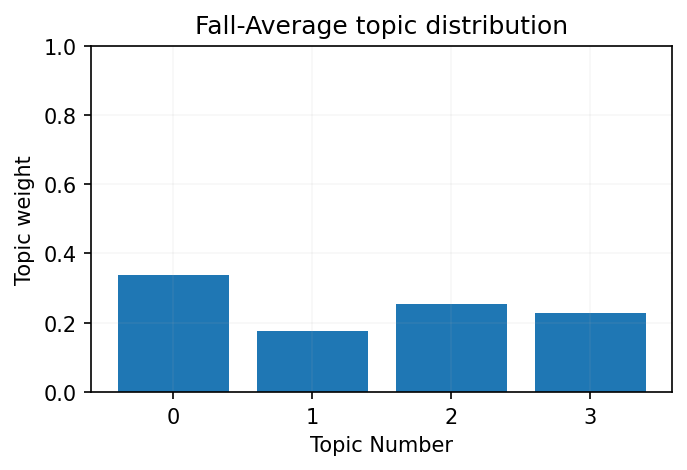

In [165]:
for season,reviews in cal_season_reviews.items():
    avg_topic_dist = get_avg_topic_dist(
        cal_ldamodel_all, cal_dictionary_all , cal_season_reviews[season],num_topics=4
    )
    plot_avg_topic_dist(avg_topic_dist, prefix=season + '-')

Similar to monthwise analysis, Topic 0 is most talked and topic 1 is least talked across all the seasons

The importance of effective crowd management at Disneyland California cannot be underestimated as it affects every visitor to the park, with millions of guests each year. The festive experiences such as Halloween and Christmas celebrations, while enjoyed by many, may not be universally appealing and could potentially bring additional crowds, causing visitors to avoid the park during those times.

### 4. Suggestion :

To improve visitors' experience and manage crowds during peak hours, Disneyland California should focus on implementing effective crowd management strategies, such as limiting visitors, improving ride queues, and increasing staff. It should also expand its festive experiences and offer unique events throughout the year, promoting them to attract more visitors. Enhancing the fireworks and parade shows, adding new attractions and experiences can help keep visitors engaged and returning. Disneyland could also consider implementing digital tools to help visitors plan their visit and make the most of their magical adventure. Improving the quality and variety of restaurant food by offering more choices, discounts, and addressing visitor complaints can further enhance the visitors' experience.